In [6]:
#pip install --user --upgrade git+https://github.com/jacobgil/pytorch-grad-cam.git


  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-9cd112a7
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-9cd112a7
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 781dbc0d16ffa95b6d18b96b7b829840a82d93d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached ttach-0.0.3-py3-none-any.whl.metadata (5.2 kB)
Using cached ttach-0.0.3-py3-none-any.whl (9.8 kB)
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=43670 sha256=d43ac6a306a8e81e6d46e1b848f8af2a0cc5da59a10a707b4d62b4cf4b3cb3bc
  Stored in directory: /tmp/pip-ephem-wheel-cache-hpl4998u/wheels/a0/4d/c8/0502c44e32030c99ffab1b98075308a1ef9829c1835537afc6
Successfully built grad-cam
Note: you may need to restart the kernel to use updated packages.


In [1]:
import sys
sys.path.append('/eos/user/f/fcampono/.local/lib/python3.11/site-packages')  

In [2]:
#import shap
import os
import numpy as np
import random
import torch
from glob import glob
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

import torch.nn as nn
from torchvision import models

In [3]:
# ==== PARAMETRI ====
batch_size = 8

random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# ==== DATASET ====
class NPYDataset(Dataset):
    def __init__(self, file_paths, labels):
        self.file_paths = file_paths
        self.labels = labels

        self.transform = T.Compose([
            T.ToTensor(),                         # [C, H, W], float32 [0,1]
            T.Resize((384, 384)),
        ])

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]
    
        img_array = np.load(img_path).astype(np.float32)
        
        # Se ha solo 2 dimensioni (H, W), la estendiamo a (H, W, 1)
        if img_array.ndim == 2:
            img_array = np.expand_dims(img_array, axis=-1)
        
        # Ora img_array ha shape (H, W, 1) se era grayscale
        if img_array.shape[-1] == 1:
            img_rgb = np.repeat(img_array, 3, axis=-1)  # Ripete il canale 3 volte → (H, W, 3)
        else:
            raise ValueError("Expected grayscale image with 1 channel")

        
        img_norm = (img_rgb - img_rgb.min())/(img_rgb.max()-img_rgb.min())    
        
        image = self.transform(img_norm)                     
    
        return image, torch.tensor(label, dtype=torch.long)

In [16]:
# ==== Percorsi ====
paths = {
    "hbb":   "/eos/user/f/fcampono/Jets_images/imgs/npy_HToBB/npy_HToBB_1000",
    "hcc":   "/eos/user/f/fcampono/Jets_images/imgs/npy_HToCC/npy_HToCC_1000",
    "hgg":   "/eos/user/f/fcampono/Jets_images/imgs/npy_HToGG/npy_HToGG_1000",
    "hww2q1l":   "/eos/user/f/fcampono/Jets_images/imgs/npy_HToWW2Q1L/npy_HToWW2Q1L_1000",
    "hww4q":   "/eos/user/f/fcampono/Jets_images/imgs/npy_HToWW4Q/npy_HToWW4Q_1000",
    "qcd":   "/eos/user/f/fcampono/Jets_images/imgs/npy_QCD/npy_QCD_1000",
    "ttbar": "/eos/user/f/fcampono/Jets_images/imgs/npy_TTBar/npy_TTBar_1000",
    "ttbarlep": "/eos/user/f/fcampono/Jets_images/imgs/npy_TTBarLep/npy_TTBarLep_1000",
    "wqq":   "/eos/user/f/fcampono/Jets_images/imgs/npy_WToQQ/npy_WToQQ_1000",
    "zqq":   "/eos/user/f/fcampono/Jets_images/imgs/npy_ZToQQ/npy_ZToQQ_1000"

}

# ==== Caricamento file ====
files = {}
for label, (name, path) in enumerate(paths.items()):
    all_files = glob(os.path.join(path, "*.npy"))
    random.shuffle(all_files)
    
    train, rest = train_test_split(all_files, test_size=0.2, random_state=42)
    val, test  = train_test_split(rest, test_size=0.2, random_state=42)
    
    files[name] = {
        "train": (train, [label]*len(train)),
        "val":   (val,   [label]*len(val)),
        "test":  (test,  [label]*len(test)),
    }

# ==== Unione dataset ====
def combine_split(split):
    file_list, label_list = [], []
    for d in files.values():
        f, l = d[split]
        file_list.extend(f)
        label_list.extend(l)
    combined = list(zip(file_list, label_list))
    random.shuffle(combined)
    return zip(*combined)

train_files, train_labels = combine_split("train")
val_files, val_labels     = combine_split("val")
test_files, test_labels   = combine_split("test")

# ==== Dataset & DataLoader ====
train_dataset = NPYDataset(train_files, train_labels)
val_dataset   = NPYDataset(val_files, val_labels)
test_dataset  = NPYDataset(test_files, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=4)


In [17]:
model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)

in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(in_features, 512),
    nn.SiLU(),
    nn.Dropout(0.35),
    nn.Linear(512, 10),
   # nn.SiLU(),
    #nn.Dropout(0.3),
   # nn.Linear(256, 2)
)

model = model.to(device)

In [18]:
for i, layer in enumerate(model.features):
    print(i, layer)

0 Conv2dNormActivation(
  (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (2): SiLU(inplace=True)
)
1 Sequential(
  (0): FusedMBConv(
    (block): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
    )
    (stochastic_depth): StochasticDepth(p=0.0, mode=row)
  )
  (1): FusedMBConv(
    (block): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
    )
    (stochastic_depth): StochasticDepth(p=0.005, mode=row)
  )
)
2 Sequential(
  (0): 

In [19]:
n_epochs = 20
early_stopping_patience = 5

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40)

In [20]:
# ====== TRAINING + EVALUATION FUNCTIONS ======
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for imgs, labels in tqdm(loader, desc="Training", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return total_loss / len(loader), correct / total

def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return total_loss / len(loader), correct / total

# ====== TRAIN LOOP ======
history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': [],
    'epoch': [], 'lr': []
}
best_val_loss = float('inf')
epochs_no_improve = 0
#best_model_path = 'best_model_augm.pt'

for epoch in range(1, n_epochs + 1):
    print(f"Epoch {epoch}/{n_epochs}")
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | LR: {current_lr:.6f}")

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['epoch'].append(epoch)
    history['lr'].append(current_lr)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        #torch.save(model.state_dict(), best_model_path) # salva i pesi
        torch.save(model, "best_pretrain_1k_10cl.pt")     # salva l'intero modello pesi + costum part 

        print("✔️ Saved best model.")
    else:
        epochs_no_improve += 1
        print(f"⚠️ No improvement for {epochs_no_improve} epoch(s).")

    if epochs_no_improve >= early_stopping_patience:
        print("🛑 Early stopping.")
        break

Epoch 1/20


Train Loss: 0.9408 | Val Loss: 0.1357 | Train Acc: 0.6773 | Val Acc: 0.9525 | LR: 0.000050
✔️ Saved best model.
Epoch 2/20


Train Loss: 0.2480 | Val Loss: 0.0664 | Train Acc: 0.9097 | Val Acc: 0.9750 | LR: 0.000050
✔️ Saved best model.
Epoch 3/20


Train Loss: 0.1707 | Val Loss: 0.0934 | Train Acc: 0.9373 | Val Acc: 0.9600 | LR: 0.000049
⚠️ No improvement for 1 epoch(s).
Epoch 4/20


Train Loss: 0.1178 | Val Loss: 0.0665 | Train Acc: 0.9570 | Val Acc: 0.9838 | LR: 0.000049
⚠️ No improvement for 2 epoch(s).
Epoch 5/20


Train Loss: 0.1162 | Val Loss: 0.0581 | Train Acc: 0.9627 | Val Acc: 0.9788 | LR: 0.000048
✔️ Saved best model.
Epoch 6/20


Train Loss: 0.1130 | Val Loss: 0.2376 | Train Acc: 0.9617 | Val Acc: 0.9100 | LR: 0.000047
⚠️ No improvement for 1 epoch(s).
Epoch 7/20


Train Loss: 0.0818 | Val Loss: 0.1258 | Train Acc: 0.9748 | Val Acc: 0.9650 | LR: 0.000046
⚠️ No improvement for 2 epoch(s).
Epoch 8/20


Train Loss: 0.0818 | Val Loss: 0.1867 | Train Acc: 0.9762 | Val Acc: 0.9575 | LR: 0.000045
⚠️ No improvement for 3 epoch(s).
Epoch 9/20


Train Loss: 0.0518 | Val Loss: 0.3160 | Train Acc: 0.9840 | Val Acc: 0.9363 | LR: 0.000044
⚠️ No improvement for 4 epoch(s).
Epoch 10/20


Train Loss: 0.0382 | Val Loss: 0.0625 | Train Acc: 0.9900 | Val Acc: 0.9762 | LR: 0.000043
⚠️ No improvement for 5 epoch(s).
🛑 Early stopping.


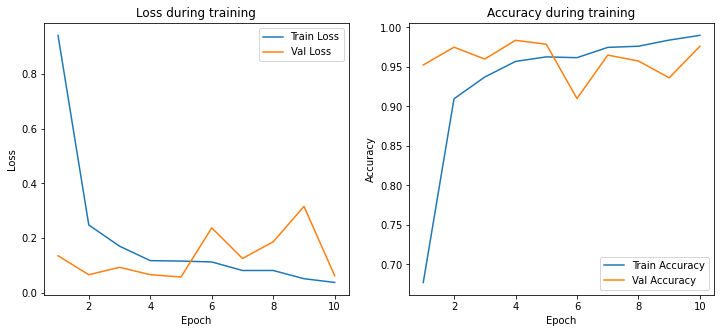

In [21]:
import matplotlib.pyplot as plt

def plot_history(history):
    epochs = history['epoch']

    plt.figure(figsize=(12,5))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss during training')
    plt.legend()

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy during training')
    plt.legend()

    plt.show()

# Dopo il training
plot_history(history)


Classification Report:
              precision    recall  f1-score   support

         hbb       0.95      0.90      0.92        20
         hcc       0.90      0.95      0.93        20
         hgg       1.00      1.00      1.00        20
     hww2q1l       1.00      1.00      1.00        20
       hww4q       1.00      1.00      1.00        20
         qcd       1.00      1.00      1.00        20
       ttbar       1.00      1.00      1.00        20
    ttbarlep       1.00      1.00      1.00        20
         wqq       0.95      1.00      0.98        20
         zqq       1.00      0.95      0.97        20

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200



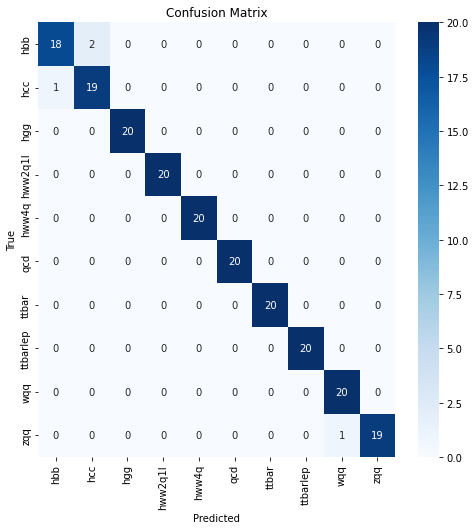

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

def test_report(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=['hbb', 'hcc', 'hgg', 'hww2q1l', 'hww4q','qcd', 'ttbar','ttbarlep', 'wqq','zqq']))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['hbb', 'hcc', 'hgg', 'hww2q1l', 'hww4q','qcd', 'ttbar','ttbarlep', 'wqq','zqq'], yticklabels=['hbb', 'hcc', 'hgg', 'hww2q1l', 'hww4q','qcd', 'ttbar','ttbarlep', 'wqq','zqq'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Usalo così, dopo il training:
test_report(model, test_loader)


In [24]:
# ====== EVAL: ANALISI CORRETTE / SBAGLIATE ======
correct_samples = []
wrong_samples = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==== Caricamento modello ====
model = torch.load('/eos/user/f/fcampono/Jet_Med_pretrain/best_pretrain_1k_10cl.pt', map_location=device)
model.to(device)
model.eval()
with torch.no_grad():
    for i, (imgs, labels) in enumerate(tqdm(test_loader, desc="Evaluating test set")):
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)

        batch_start_idx = i * batch_size
        batch_paths = test_files[batch_start_idx : batch_start_idx + len(imgs)]

        for path, pred, true_label in zip(batch_paths, preds.cpu().numpy(), labels.cpu().numpy()):
            if pred == true_label:
                correct_samples.append((path, true_label, pred))
            else:
                wrong_samples.append((path, true_label, pred))


/tmp/ipykernel_349/1963251987.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/eos/user/f/fcampono/Jet_Med_pretrain/best_pretrain_1k_10cl.pt', map_lo

In [25]:
# label = 1 --> hcc
# label = 0 --> hbb

#wrong_samples
correct_samples

[('/eos/user/f/fcampono/Jets_images/imgs/npy_ZToQQ/npy_ZToQQ_1000/ZToQQ_1000_fileroot_004_id_409.npy',
  9,
  9),
 ('/eos/user/f/fcampono/Jets_images/imgs/npy_TTBar/npy_TTBar_1000/TTBar_1000_fileroot_001_id_109.npy',
  6,
  6),
 ('/eos/user/f/fcampono/Jets_images/imgs/npy_ZToQQ/npy_ZToQQ_1000/ZToQQ_1000_fileroot_004_id_435.npy',
  9,
  9),
 ('/eos/user/f/fcampono/Jets_images/imgs/npy_TTBarLep/npy_TTBarLep_1000/TTBarLep_1000_fileroot_001_id_161.npy',
  7,
  7),
 ('/eos/user/f/fcampono/Jets_images/imgs/npy_HToWW2Q1L/npy_HToWW2Q1L_1000/HToWW2Q1L_1000_fileroot_000_id_063.npy',
  3,
  3),
 ('/eos/user/f/fcampono/Jets_images/imgs/npy_HToWW2Q1L/npy_HToWW2Q1L_1000/HToWW2Q1L_1000_fileroot_000_id_024.npy',
  3,
  3),
 ('/eos/user/f/fcampono/Jets_images/imgs/npy_HToBB/npy_HToBB_1000/HToBB_1000_fileroot_001_id_128.npy',
  0,
  0),
 ('/eos/user/f/fcampono/Jets_images/imgs/npy_ZToQQ/npy_ZToQQ_1000/ZToQQ_1000_fileroot_000_id_080.npy',
  9,
  9),
 ('/eos/user/f/fcampono/Jets_images/imgs/npy_HToWW4Q/np

/tmp/ipykernel_349/315804670.py:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/eos/user/f/fcampono/Jet_Med_pretrain/best_pretrain_1k_10cl.pt', map_lo

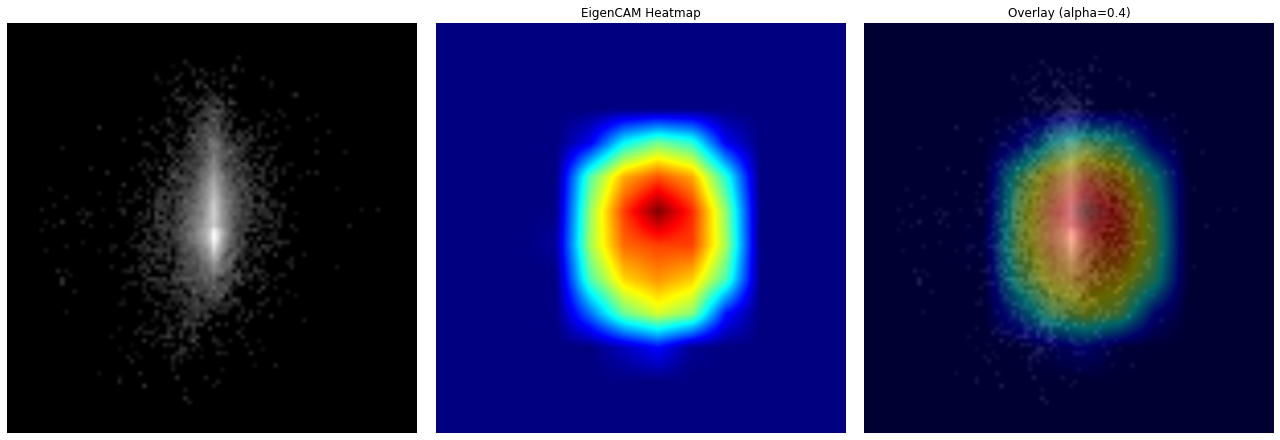

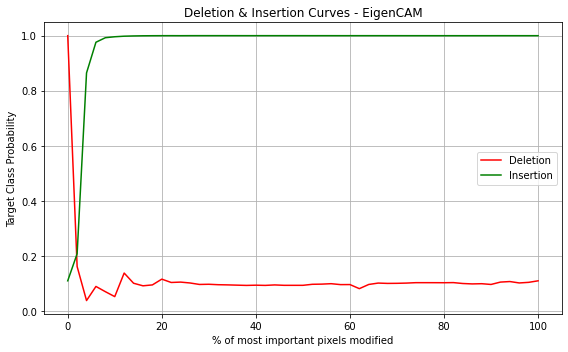

In [29]:
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.nn.functional as F
from pytorch_grad_cam import GradCAM, EigenCAM, LayerCAM, ShapleyCAM, EigenGradCAM, ScoreCAM, HiResCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==== Preprocessing identico al dataset ====
def preprocess_npy_image(npy_path):
    image = np.load(npy_path).astype(np.float32)  # [100, 100]
    image /= np.max(image)  # Normalizzazione per immagine

    image = np.stack([image] * 3, axis=-1)  # [H, W, 3]

    transform = transforms.Compose([
        transforms.ToTensor(),            # [H, W, C] -> [C, H, W]
        transforms.Resize((384, 384)),    # Resize
    ])
    image_tensor = transform(image)  # Tensor [3, 384, 384]
    return image_tensor, image  # Tensor, immagine originale per visualizzazione

# =======================
# Funzioni Deletion/Insertion (versione fedele con baseline)
# =======================
def apply_mask(image: torch.Tensor, mask: np.ndarray, mode='deletion', baseline=None) -> torch.Tensor:
    device = image.device
    mask_t = torch.tensor(mask, dtype=torch.float32, device=device)  # [H, W]
    mask_t = mask_t.unsqueeze(0)  # [1, H, W]
    mask_t = mask_t.expand_as(image)  # espande su canali (C,H,W)

    if baseline is None:
        baseline = torch.zeros_like(image).to(device)

    if mode == 'deletion':
        return image * (1 - mask_t) + baseline * mask_t
    elif mode == 'insertion':
        return baseline * (1 - mask_t) + image * mask_t
    else:
        raise ValueError("Mode must be 'deletion' or 'insertion'.")


def run_curve(model, image: torch.Tensor, cam: np.ndarray, target_class: int, mode='deletion', steps=50, baseline=None):
    model.eval()
    image = image.clone().detach().unsqueeze(0).to(next(model.parameters()).device)
    cam = cv2.resize(cam, (image.shape[2], image.shape[3]))  # Resize CAM
    cam = cam / (cam.max() + 1e-8)

    flat = cam.flatten()
    sorted_indices = np.argsort(flat)[::-1]

    scores = []
    for i in range(steps + 1):
        percent = i / steps
        num_pixels = int(flat.size * percent)

        mask = np.zeros_like(flat)
        mask[sorted_indices[:num_pixels]] = 1
        mask = mask.reshape(cam.shape)

        masked_image = apply_mask(image[0], mask, mode=mode, baseline=baseline).unsqueeze(0)

        with torch.no_grad():
            output = F.softmax(model(masked_image), dim=1)
            score = output[0, target_class].item()
            scores.append(score)

    return scores

def plot_curves(del_scores, ins_scores, title="Deletion & Insertion Curves"):
    x = np.linspace(0, 100, len(del_scores))
    plt.figure(figsize=(8, 5))
    plt.plot(x, del_scores, label="Deletion", color="red")
    plt.plot(x, ins_scores, label="Insertion", color="green")
    plt.xlabel("% of most important pixels modified")
    plt.ylabel("Target Class Probability")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# =======================
# Main pipeline
# =======================
if __name__ == "__main__":
    npy_path = "/eos/user/f/fcampono/Jets_images/imgs/npy_ZToQQ/npy_ZToQQ_1000/ZToQQ_1000_fileroot_004_id_435.npy"
    input_tensor, vis_image = preprocess_npy_image(npy_path)
    input_tensor = input_tensor.unsqueeze(0).to(device)

    model = torch.load('/eos/user/f/fcampono/Jet_Med_pretrain/best_pretrain_1k_10cl.pt', map_location=device)
    model.to(device)
    model.eval()

    with torch.no_grad():
        output = model(input_tensor)
        pred_label = torch.argmax(output, dim=1).item()

    target_layer = model.features[-1]
    cam = GradCAM(model=model, target_layers=[target_layer])
    grayscale_cam = cam(input_tensor, targets=[ClassifierOutputTarget(pred_label)])[0]

    # Visualizzazione heatmap + overlay
    heatmap = cv2.applyColorMap(np.uint8(255 * grayscale_cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0

    vis_image_resized = cv2.resize(vis_image, (384, 384))
    vis_image_resized = np.clip(vis_image_resized, 0, 1)

    alpha = 0.4
    overlay = (1 - alpha) * vis_image_resized + alpha * heatmap
    overlay = np.clip(overlay, 0, 1)

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    axs[0].imshow(vis_image_resized)
    #axs[0].set_title("/eos/user/f/fcampono/Jets_images/imgs/npy_TTBar/npy_TTBar_1000/TTBar_1000_fileroot_001_id_159.npy")
    axs[1].imshow(heatmap)
    axs[1].set_title("EigenCAM Heatmap")
    axs[2].imshow(overlay)
    axs[2].set_title(f"Overlay (alpha={alpha})")
    for ax in axs:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

    # Baseline nera per Deletion/Insertion
    baseline_img = torch.zeros_like(input_tensor[0])

    # Calcola curve
    del_scores = run_curve(model, input_tensor[0], grayscale_cam, pred_label, mode='deletion', steps=50, baseline=baseline_img)
    ins_scores = run_curve(model, input_tensor[0], grayscale_cam, pred_label, mode='insertion', steps=50, baseline=baseline_img)

    # Visualizza metriche
    plot_curves(del_scores, ins_scores, title="Deletion & Insertion Curves - EigenCAM")



In [30]:
from sklearn.metrics import auc

def compute_auc(scores: list) -> float:
    x = np.linspace(0, 1, len(scores))
    return auc(x, scores)
del_auc = compute_auc(del_scores)
ins_auc = compute_auc(ins_scores)

print(f"📉 Deletion AUC: {del_auc:.4f}")
print(f"📈 Insertion AUC: {ins_auc:.4f})")

📉 Deletion AUC: 0.1071
📈 Insertion AUC: 0.9714)


In [28]:
import torch
import numpy as np

# Imposta il dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carica il modello
model = torch.load('/eos/user/f/fcampono/Jet_Med_pretrain/best_pretrain_1k_10cl.pt', map_location=device)
model.to(device)
model.eval()

# Crea un'immagine completamente nera con forma [1, 3, 384, 384]
black_input = torch.zeros((1, 3, 384, 384), dtype=torch.float32).to(device)

# Ottieni predizione
with torch.no_grad():
    output = model(black_input)
    prob = torch.nn.functional.softmax(output, dim=1)
    pred_class = torch.argmax(prob, dim=1).item()
    conf = prob[0, pred_class].item()

# Mostra il risultato
print(f"🧪 Predizione su baseline nera:")
print(f"Classe predetta: {pred_class} (con confidenza {conf:.4f})")


/tmp/ipykernel_349/2921836124.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/eos/user/f/fcampono/Jet_Med_pretrain/best_pretrain_1k_10cl.pt', map_lo

🧪 Predizione su baseline nera:
Classe predetta: 5 (con confidenza 0.1321)


In [17]:
import numpy as np
import torch
import torch.nn.functional as F
import cv2
from tqdm import tqdm
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import matplotlib.pyplot as plt

# ==== Preparazione CAM ====
model = torch.load('/eos/user/f/fcampono/Jets_images/simulations_bug_fixing/best_pretrain_1k.pt', map_location=device)

model.eval()
target_layer = model.features[-1]
cam_extractor = EigenCAM(model=model, target_layers=[target_layer])

# ==== Liste per AUC ====
deletion_aucs_all = []
insertion_aucs_all = []

# Split per classi
deletion_aucs_class0 = []
insertion_aucs_class0 = []

deletion_aucs_class1 = []
insertion_aucs_class1 = []

deletion_aucs_class2 = []
insertion_aucs_class2 = []

deletion_aucs_class3 = []
insertion_aucs_class3 = []

# ==== Inference + Analisi ====
for inputs, labels in tqdm(test_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)

    for i in range(inputs.size(0)):
        input_tensor = inputs[i].unsqueeze(0)
        true_label = labels[i].item()
        pred_label = preds[i].item()
    
        # 🔒 CONTROLLA che la predizione sia corretta
        #if pred_label != true_label:
         #   continue  # Salta questo esempio


        # CAM per la classe predetta
        grayscale_cam = cam_extractor(
            input_tensor, targets=[ClassifierOutputTarget(pred_label)])[0]

        baseline_img = torch.zeros_like(input_tensor[0])

        del_scores = run_curve(
            model, input_tensor[0], grayscale_cam, pred_label,
            mode='deletion', steps=50, baseline=baseline_img
        )
        ins_scores = run_curve(
            model, input_tensor[0], grayscale_cam, pred_label,
            mode='insertion', steps=50, baseline=baseline_img
        )

        # AUC
        x = np.linspace(0, 1, len(del_scores))
        auc_del = np.trapz(del_scores, x)
        auc_ins = np.trapz(ins_scores, x)

        # Salva globali
        deletion_aucs_all.append(auc_del)
        insertion_aucs_all.append(auc_ins)

        # Salva per classe
        if true_label == 0:
            deletion_aucs_class0.append(auc_del)
            insertion_aucs_class0.append(auc_ins)
        elif true_label == 1:
            deletion_aucs_class1.append(auc_del)
            insertion_aucs_class1.append(auc_ins)
        elif true_label == 2:
            deletion_aucs_class2.append(auc_del)
            insertion_aucs_class2.append(auc_ins)
        elif true_label == 3:
            deletion_aucs_class3.append(auc_del)
            insertion_aucs_class3.append(auc_ins)


# ==== RISULTATI ====

print("\n=== RISULTATI DELETION/INSERTION ===")
def print_stats(name, del_list, ins_list):
    del_mean = np.mean(del_list)
    del_std_err = np.std(del_list, ddof=1) / np.sqrt(len(del_list))

    ins_mean = np.mean(ins_list)
    ins_std_err = np.std(ins_list, ddof=1) / np.sqrt(len(ins_list))

    print(f"\n📊 {name}")
    print(f"  📉 AUC Deletion media: {del_mean:.3f} ± {del_std_err:.3f}")
    print(f"  📈 AUC Insertion media: {ins_mean:.3f} ± {ins_std_err:.3f}")

print_stats("Totale", deletion_aucs_all, insertion_aucs_all)
print_stats("Classe 0 (es: TTBar)", deletion_aucs_class0, insertion_aucs_class0)
print_stats("Classe 1 (es: QCD)", deletion_aucs_class1, insertion_aucs_class1)
print_stats("Classe 2 (es: HToBB)", deletion_aucs_class2, insertion_aucs_class2)
print_stats("Classe 3 (es: HToCC)", deletion_aucs_class3, insertion_aucs_class3)


/tmp/ipykernel_49999/3824501986.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/eos/user/f/fcampono/Jets_images/simulations_bug_fixing/best_pretrai


=== RISULTATI DELETION/INSERTION ===

📊 Totale
  📉 AUC Deletion media: 0.290 ± 0.007
  📈 AUC Insertion media: 0.886 ± 0.016

📊 Classe 0 (es: TTBar)
  📉 AUC Deletion media: 0.319 ± 0.005
  📈 AUC Insertion media: 0.933 ± 0.005

📊 Classe 1 (es: QCD)
  📉 AUC Deletion media: 0.295 ± 0.011
  📈 AUC Insertion media: 0.936 ± 0.004

📊 Classe 2 (es: HToBB)
  📉 AUC Deletion media: 0.250 ± 0.005
  📈 AUC Insertion media: 0.818 ± 0.036

📊 Classe 3 (es: HToCC)
  📉 AUC Deletion media: 0.296 ± 0.004
  📈 AUC Insertion media: 0.857 ± 0.027


# Medical images: NLST database with pretrained 

In [3]:

import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image

class MixedFolderDataset(Dataset):
    def __init__(self, root_dir, transform=None, allowed_exts=(".npy", ".png", ".jpg", ".jpeg")):
        self.root_dir = root_dir
        self.transform = transform
        self.allowed_exts = allowed_exts
        self.samples = []

        for class_name in os.listdir(root_dir):
            class_path = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_path):
                continue

            for fname in os.listdir(class_path):
                if fname.startswith("."):
                    continue  # ignora file nascosti
                if not fname.lower().endswith(self.allowed_exts):
                    continue  # ignora file con estensioni non previste

                full_path = os.path.join(class_path, fname)
                if os.path.isdir(full_path):
                    continue  # ignora eventuali cartelle

                self.samples.append((full_path, class_name))

        # mappa classi a indici
        classes = sorted(set([c for _, c in self.samples]))
        self.class_to_idx = {cls: i for i, cls in enumerate(classes)}
        self.classes = classes

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, class_name = self.samples[idx]

        # --- caricamento immagine ---
        if path.lower().endswith(".npy"):
            img = np.load(path).astype(np.float32)

            if img.ndim == 2:
                img = np.expand_dims(img, axis=-1)

            if img.ndim == 3:
                if img.shape[-1] == 1:
                    img = np.repeat(img, 3, axis=-1)
                elif img.shape[-1] == 3:
                    pass
                else:
                    raise ValueError(f"Expected 1 or 3 channels, got {img.shape[-1]}")
            else:
                raise ValueError(f"Unexpected image dimensions: {img.shape}")

            img_norm = (img - img.min()) / (img.max() - img.min() + 1e-8)
            img_pil = Image.fromarray((img_norm * 255).astype(np.uint8))

        else:  # PNG/JPG
            img_pil = Image.open(path).convert("RGB")

        # --- trasformazioni ---
        if self.transform:
            img = self.transform(img_pil)
        else:
            img = torch.from_numpy(np.array(img_pil)).permute(2, 0, 1).float() / 255.

        label = self.class_to_idx[class_name]
        return img, torch.tensor(label, dtype=torch.long)


In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report

# ----- CONFIG -----
DATA_DIR = "/eos/user/f/fcampono/PRIN_MedImgs/NLST_imgs"
MODEL_PATH = "/eos/user/f/fcampono/Jet_Med_pretrain/best_pretrain_1k_10cl.pt"
BATCH_SIZE = 32
NUM_CLASSES = 2
NUM_EPOCHS = 35
LR = 1e-4
WD = 1e-7
T_lr = 41

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----- DATASET -----

train_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    #transforms.RandomResizedCrop(384, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor()])


transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor()])

train_dataset = MixedFolderDataset(os.path.join(DATA_DIR, "train"), transform=train_transform)
val_dataset = MixedFolderDataset(os.path.join(DATA_DIR, "validation"), transform=transform)
test_dataset = MixedFolderDataset(os.path.join(DATA_DIR, "test"), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [5]:
# ----- MODEL -----
model = torch.load(MODEL_PATH, map_location=DEVICE)

# Sostituzione del classifier finale
#in_features = model.classifier[-1].in_features
#model.classifier[-1] = nn.Linear(in_features, NUM_CLASSES)

in_features = model.classifier[0].in_features
model.classifier = nn.Sequential(
    nn.Linear(in_features, 512),
    nn.SiLU(),
    nn.Dropout(0.35), 
    nn.Linear(512, 2),

   # nn.SiLU(),
    #nn.Dropout(0.3),
   # nn.Linear(256, 2)
)


model = model.to(DEVICE)

# ----- LOSS & OPTIMIZER -----
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_lr)


# ===

# model 01: ultimi 3 layer free
# model 02: ultimo layer free

# Congela tutti i layer tranne il classifier
# Congela tutta la backbone

for param in model.features.parameters():
    param.requires_grad = False
    
# Sblocca ultimi 3 blocchi (penultimo e ultimo)
for block in list(model.features)[-3:]:
    for param in block.parameters():
        param.requires_grad = True

/tmp/ipykernel_560/4122514769.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(MODEL_PATH, map_location=DEVICE)


In [6]:
from tqdm import tqdm
import torch

# ====== TRAINING + EVALUATION FUNCTIONS ======
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0, 0, 0
    loop = tqdm(loader, desc="Training", leave=False)
    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        acc = 100 * correct / total
        avg_loss = total_loss / (total / loader.batch_size)
        loop.set_postfix(loss=f"{avg_loss:.4f}", acc=f"{acc:.2f}%")

    return total_loss / len(loader), correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    loop = tqdm(loader, desc="Evaluating", leave=False)
    with torch.no_grad():
        for imgs, labels in loop:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            acc = 100 * correct / total
            avg_loss = total_loss / (total / loader.batch_size)
            loop.set_postfix(loss=f"{avg_loss:.4f}", acc=f"{acc:.2f}%")

    return total_loss / len(loader), correct / total


# ====== TRAIN LOOP ======
history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': [],
    'epoch': [], 'lr': []
}

best_val_loss = float('inf')
epochs_no_improve = 0
early_stopping_patience = 5
#best_model_path = '/eos/user/f/fcampono/Pretrain_NLST_jet/best_weights.pt'

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"Epoch {epoch}/{NUM_EPOCHS}")

    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)
    val_loss, val_acc = evaluate(model, val_loader, criterion, DEVICE)
   # scheduler.step()

    # Se usi scheduler, ricordati di chiamare scheduler.step() qui
    # scheduler.step()

    current_lr = optimizer.param_groups[0]['lr']

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}% | LR: {current_lr:.6f}")

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['epoch'].append(epoch)
    history['lr'].append(current_lr)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        #torch.save(model.state_dict(), best_model_path)  # salva solo pesi
        #torch.save(model, "best_pretrain_med_02.pt")             # salva intero modello
        torch.save(model, "best_pretrain_jet_med_02.pt")             # salva intero modello

        print("✔️ Saved best model.")
    else:
        epochs_no_improve += 1
        print(f"⚠️ No improvement for {epochs_no_improve} epoch(s).")

    if epochs_no_improve >= early_stopping_patience:
        print("🛑 Early stopping.")
        break

Epoch 1/35


Train Loss: 0.6793 | Val Loss: 0.6494 | Train Acc: 57.40% | Val Acc: 61.68% | LR: 0.000100
✔️ Saved best model.
Epoch 2/35


Train Loss: 0.5934 | Val Loss: 0.6092 | Train Acc: 69.25% | Val Acc: 63.55% | LR: 0.000100
✔️ Saved best model.
Epoch 3/35


Train Loss: 0.5150 | Val Loss: 0.5547 | Train Acc: 74.94% | Val Acc: 66.36% | LR: 0.000100
✔️ Saved best model.
Epoch 4/35


Train Loss: 0.4534 | Val Loss: 0.5277 | Train Acc: 78.13% | Val Acc: 69.16% | LR: 0.000100
✔️ Saved best model.
Epoch 5/35


Train Loss: 0.4103 | Val Loss: 0.5817 | Train Acc: 81.32% | Val Acc: 70.09% | LR: 0.000100
⚠️ No improvement for 1 epoch(s).
Epoch 6/35


Train Loss: 0.4091 | Val Loss: 0.5598 | Train Acc: 82.00% | Val Acc: 70.09% | LR: 0.000100
⚠️ No improvement for 2 epoch(s).
Epoch 7/35


Train Loss: 0.3409 | Val Loss: 0.5806 | Train Acc: 85.42% | Val Acc: 68.22% | LR: 0.000100
⚠️ No improvement for 3 epoch(s).
Epoch 8/35


Train Loss: 0.2515 | Val Loss: 0.7812 | Train Acc: 88.84% | Val Acc: 71.03% | LR: 0.000100
⚠️ No improvement for 4 epoch(s).
Epoch 9/35


Train Loss: 0.2693 | Val Loss: 0.8028 | Train Acc: 88.84% | Val Acc: 75.70% | LR: 0.000100
⚠️ No improvement for 5 epoch(s).
🛑 Early stopping.


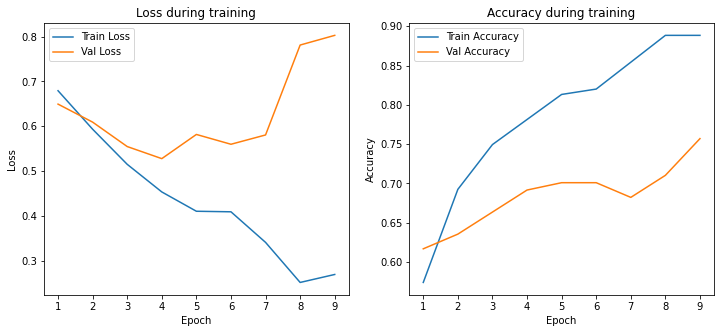

In [7]:
import matplotlib.pyplot as plt

def plot_history(history, unfreeze_epoch=None):
    epochs = history['epoch']

    plt.figure(figsize=(12,5))

    # ----- Loss -----
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss during training')
    plt.legend()

    # ----- Accuracy -----
    plt.subplot(1,2,2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy during training')
    plt.legend()

    plt.show()

# Dopo il training
plot_history(history)

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.86      0.82        57
           1       0.80      0.70      0.75        47

    accuracy                           0.79       104
   macro avg       0.79      0.78      0.78       104
weighted avg       0.79      0.79      0.79       104



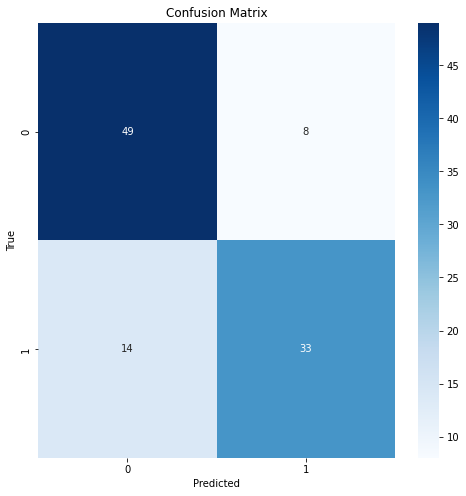

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def test_report(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=['0', '1']))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Usalo così, dopo il training:
test_report(model, test_loader)


In [12]:
def evaluate_with_paths(model, loader, device):
    model.eval()
    correct_paths, wrong_paths = [], []

    all_samples = loader.dataset.samples  # contiene (path, class)
    idx = 0

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Testing"):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)

            batch_size = labels.size(0)
            batch_paths = [all_samples[i][0] for i in range(idx, idx + batch_size)]
            idx += batch_size

            for p, pred, gt in zip(batch_paths, preds.cpu().numpy(), labels.cpu().numpy()):
                if pred == gt:
                    correct_paths.append(p)
                else:
                    wrong_paths.append(p)

    return correct_paths, wrong_paths
correct_paths, wrong_paths = evaluate_with_paths(model, test_loader, DEVICE)

print("✔️ Immagini corrette:", len(correct_paths))
print("❌ Immagini sbagliate:", len(wrong_paths))

with open("correct_test_paths.txt", "w") as f:
    f.write("\n".join(correct_paths))

with open("wrong_test_paths.txt", "w") as f:
    f.write("\n".join(wrong_paths))


Testing: 100%|██████████| 4/4 [00:05<00:00,  1.31s/it]

✔️ Immagini corrette: 76
❌ Immagini sbagliate: 28


/tmp/ipykernel_560/2879142338.py:116: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/eos/user/f/fcampono/Jet_Med_pretrain/best_pretrain_jet_med_02.pt', m

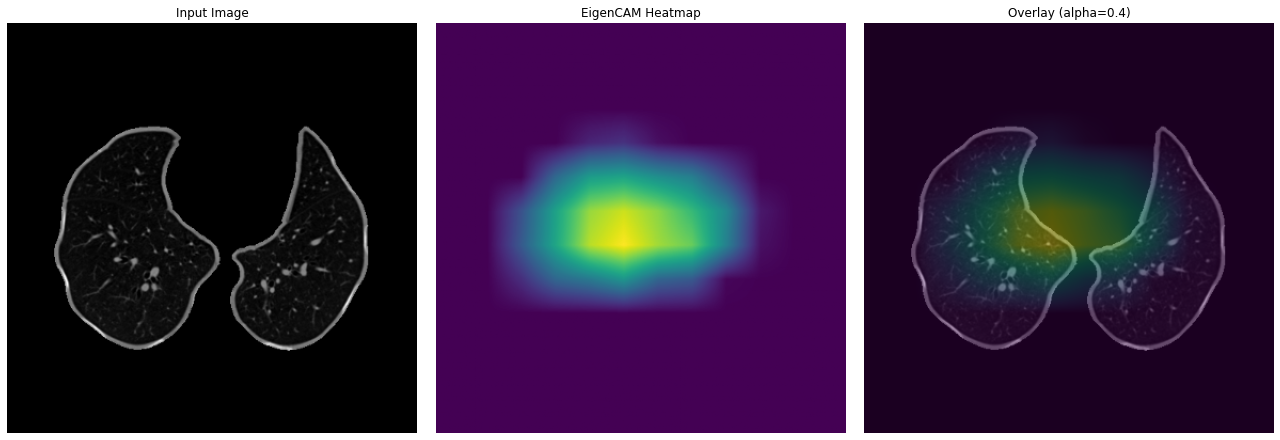

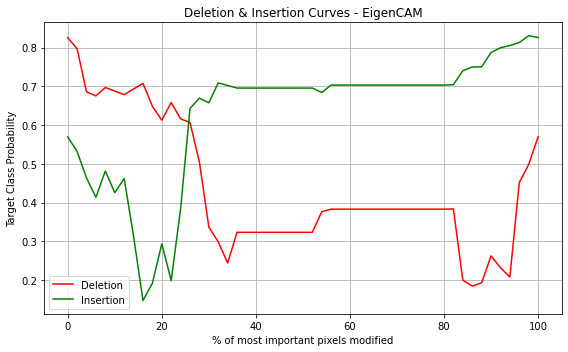

In [30]:
import os
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.nn.functional as F
from PIL import Image

from pytorch_grad_cam import (
    GradCAM, EigenCAM, LayerCAM, ShapleyCAM, EigenGradCAM,
    ScoreCAM, HiResCAM, GradCAMPlusPlus
)
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==== Preprocessing per NPY/PNG/JPG ====
def preprocess_image(path, img_size=384):
    ext = os.path.splitext(path)[-1].lower()

    if ext == ".npy":
        image = np.load(path).astype(np.float32)
        image /= (np.max(image) + 1e-8)  # normalizzazione

        if image.ndim != 3:
            image = np.stack([image] * 3, axis=-1)  # [H, W, 3]

    elif ext in [".png", ".jpg", ".jpeg"]:
        image = Image.open(path).convert("RGB")
        image = np.array(image).astype(np.float32) / 255.0

    else:
        raise ValueError(f"Formato non supportato: {ext}")

    transform = transforms.Compose([
        transforms.ToTensor(),               # [H, W, C] -> [C, H, W]
        transforms.Resize((img_size, img_size)),
    ])
    image_tensor = transform(image)
    return image_tensor, image


# =======================
# Funzioni Deletion/Insertion
# =======================
def apply_mask(image: torch.Tensor, mask: np.ndarray, mode='deletion', baseline=None) -> torch.Tensor:
    device = image.device
    mask_t = torch.tensor(mask, dtype=torch.float32, device=device)  # [H, W]
    mask_t = mask_t.unsqueeze(0).expand_as(image)  # [C, H, W]

    if baseline is None:
        baseline = torch.zeros_like(image).to(device)

    if mode == 'deletion':
        return image * (1 - mask_t) + baseline * mask_t
    elif mode == 'insertion':
        return baseline * (1 - mask_t) + image * mask_t
    else:
        raise ValueError("Mode must be 'deletion' or 'insertion'.")


def run_curve(model, image: torch.Tensor, cam: np.ndarray, target_class: int,
              mode='deletion', steps=50, baseline=None):
    model.eval()
    image = image.clone().detach().unsqueeze(0).to(next(model.parameters()).device)
    cam = cv2.resize(cam, (image.shape[2], image.shape[3]))  # Resize CAM
    cam = cam / (cam.max() + 1e-8)

    flat = cam.flatten()
    sorted_indices = np.argsort(flat)[::-1]

    scores = []
    for i in range(steps + 1):
        percent = i / steps
        num_pixels = int(flat.size * percent)

        mask = np.zeros_like(flat)
        mask[sorted_indices[:num_pixels]] = 1
        mask = mask.reshape(cam.shape)

        masked_image = apply_mask(image[0], mask, mode=mode, baseline=baseline).unsqueeze(0)

        with torch.no_grad():
            output = F.softmax(model(masked_image), dim=1)
            score = output[0, target_class].item()
            scores.append(score)

    return scores


def plot_curves(del_scores, ins_scores, title="Deletion & Insertion Curves"):
    x = np.linspace(0, 100, len(del_scores))
    plt.figure(figsize=(8, 5))
    plt.plot(x, del_scores, label="Deletion", color="red")
    plt.plot(x, ins_scores, label="Insertion", color="green")
    plt.xlabel("% of most important pixels modified")
    plt.ylabel("Target Class Probability")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# =======================
# Main pipeline
# =======================
if __name__ == "__main__":
    img_path = "/eos/user/f/fcampono/PRIN_MedImgs/NLST_imgs/test/benigne/117301_0_1.2.840.113654.2.55.189831537707752554735628842750133067841_113_6_lobe.png"
    input_tensor, vis_image = preprocess_image(img_path)
    input_tensor = input_tensor.unsqueeze(0).to(device)

    # Carica modello
    model = torch.load('/eos/user/f/fcampono/Jet_Med_pretrain/best_pretrain_jet_med_02.pt', map_location=device)
    model.to(device)
    model.eval()

    # Predizione
    with torch.no_grad():
        output = model(input_tensor)
        pred_label = torch.argmax(output, dim=1).item()

    # GradCAM
    target_layer = model.features[-1]
    cam = EigenCAM(model=model, target_layers=[target_layer])
    grayscale_cam = cam(input_tensor, targets=[ClassifierOutputTarget(pred_label)])[0]

    # Visualizzazione heatmap + overlay
    heatmap = cv2.applyColorMap(np.uint8(255 * grayscale_cam), cv2.COLORMAP_VIRIDIS)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0

    vis_image_resized = cv2.resize(vis_image, (384, 384))
    vis_image_resized = np.clip(vis_image_resized, 0, 1)

    alpha = 0.4
    overlay = (1 - alpha) * vis_image_resized + alpha * heatmap
    overlay = np.clip(overlay, 0, 1)

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    axs[0].imshow(vis_image_resized)
    axs[0].set_title("Input Image")
    axs[1].imshow(heatmap)
    axs[1].set_title("EigenCAM Heatmap")
    axs[2].imshow(overlay)
    axs[2].set_title(f"Overlay (alpha={alpha})")
    for ax in axs:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

    # Baseline nera per Deletion/Insertion
    baseline_img = torch.zeros_like(input_tensor[0])

    # Calcola curve
    del_scores = run_curve(model, input_tensor[0], grayscale_cam, pred_label,
                           mode='deletion', steps=50, baseline=baseline_img)
    ins_scores = run_curve(model, input_tensor[0], grayscale_cam, pred_label,
                           mode='insertion', steps=50, baseline=baseline_img)

    # Visualizza metriche
    plot_curves(del_scores, ins_scores, title="Deletion & Insertion Curves - EigenCAM")


In [31]:
from sklearn.metrics import auc

def compute_auc(scores: list) -> float:
    x = np.linspace(0, 1, len(scores))
    return auc(x, scores)
del_auc = compute_auc(del_scores)
ins_auc = compute_auc(ins_scores)

print(f"📉 Deletion AUC: {del_auc:.4f}")
print(f"📈 Insertion AUC: {ins_auc:.4f})")

📉 Deletion AUC: 0.4347
📈 Insertion AUC: 0.6292)


Trovate 10 cartelle con '_1000'.


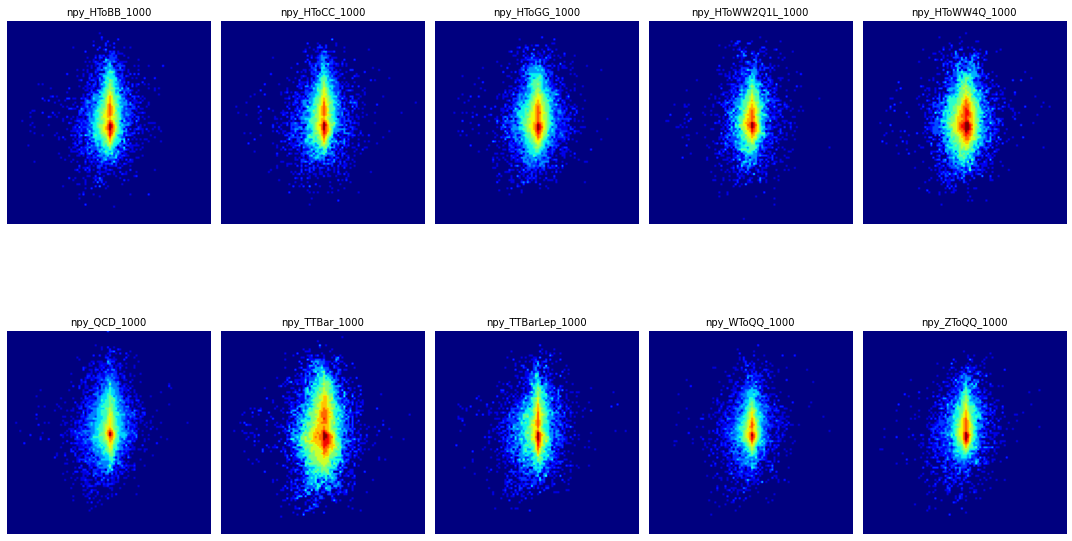

In [ ]:
# What the jets images are...

import os
import numpy as np
import matplotlib.pyplot as plt

BASE_DIR = "/eos/user/f/fcampono/Jets_images/imgs/"

# Trova tutte le sottocartelle *_1000
folders_1000 = []
for root, dirs, files in os.walk(BASE_DIR):
    for d in dirs:
        if d.endswith("1000"):
            folders_1000.append(os.path.join(root, d))

print(f"Trovate {len(folders_1000)} cartelle con '_1000'.")

# Carica la prima immagine di ogni cartella
images, titles = [], []
for folder in sorted(folders_1000):
    files = [f for f in os.listdir(folder) if not f.startswith(".")]
    if not files:
        continue
    first_file = os.path.join(folder, sorted(files)[0])
    titles.append(os.path.basename(folder))

    if first_file.endswith(".npy"):
        img = np.load(first_file)

    images.append(img)

# Plot con 3 immagini per riga
n = len(images)
cols = 5
rows = (n + cols - 1) // cols

plt.figure(figsize=(15, 5 * rows))
for i, (img, title) in enumerate(zip(images, titles)):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img.astype(np.uint8), cmap= 'jet')
    plt.title(title, fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()
